In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.optimize import differential_evolution

import warnings
warnings.filterwarnings('ignore')

In [31]:
# Load dataset
df = pd.read_csv("../data.csv")

# Select relevant columns
columns_to_select = [
    'C', 'Mn', 'S', 'P', 'Si', 'Ni', 'Cr', 'Cu', 
    'Ti', 'Co', 'N', 'Pb', 'Sn', 'Al', 'B', 'V', 
    'Ca', 'Nb', 'CAPL MAIN DEFECT'
]

df = df[columns_to_select]

# Split into features and target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [32]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Assuming X_scaled and y_encoded are already prepared
# Train on 100% data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y_encoded)


print("✅ Random Forest model trained on 100% data")

✅ Random Forest model trained on 100% data


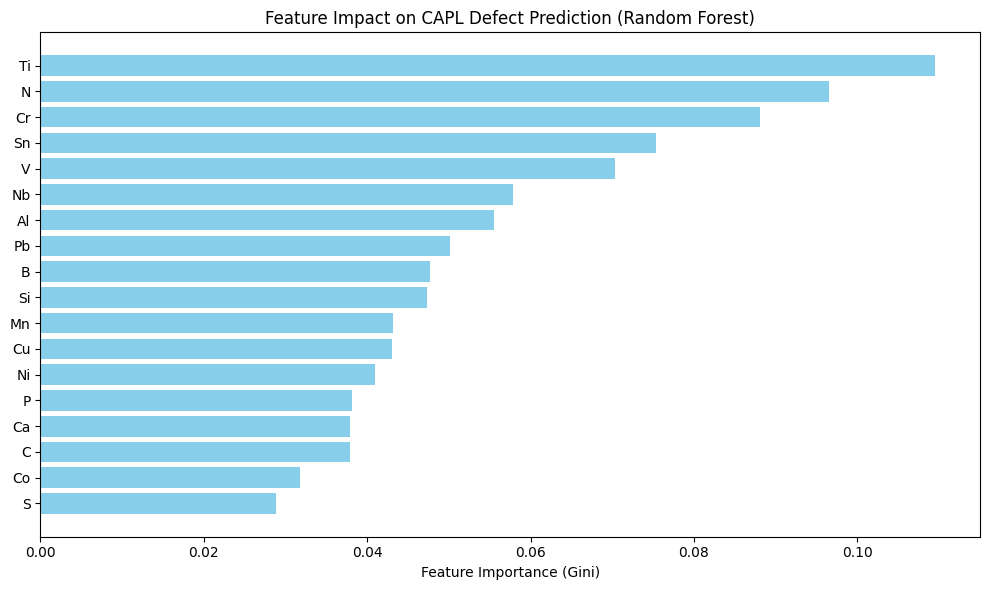

In [34]:
feature_names = X.columns
feature_importances = rf.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance (Gini)")
plt.title("Feature Impact on CAPL Defect Prediction (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [35]:
custom_input_data = np.array([[69, 3200, 15, 310, 4000, 1600, 173500, 500,
                               3200, 400, 100, 45, 50, 365, 5, 440, 10, 20]])


custom_input_scaled = scaler.transform(custom_input_data)
predicted_label_encoded = rf.predict(custom_input_scaled)
predicted_probabilities = rf.predict_proba(custom_input_scaled)
predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

print(f"\nRandom Forest\n=> Predicted Defect: {predicted_label[0]}\n")

print("\n## Class Probabilities (Most to Least Likely):\n")
class_probs = list(zip(label_encoder.classes_, predicted_probabilities[0]))
for label, prob in sorted(class_probs, key=lambda x: x[1], reverse=True):
    print(f"{label}: {prob:.4f}")


Random Forest
=> Predicted Defect: Inclusion Free


## Class Probabilities (Most to Least Likely):

Inclusion Free: 0.6906
Spinel Inclusion: 0.3094
Casting Powder Inclusion: 0.0000
HOLE: 0.0000
ROLL PICK-UP MARK- BODY: 0.0000
ROLL PICK-UP MARK- EDGE: 0.0000
SLAB EDGE: 0.0000
SLIVER B-BODY: 0.0000
SLIVER C-BODY: 0.0000
SLIVER C-EDGE: 0.0000
TI STREAKS: 0.0000


In [36]:
initial_scaled_input = scaler.transform(custom_input_data)[0]

feature_bounds = [
    (0, 100), (2000, 3500), (0, 30), (200, 500), (2500, 5200), (0, 3000),
    (112000, 174000), (0, 2000), (2000, 3500), (0, 500), (0, 125), (0, 45),
    (0, 50), (100, 500), (0, 50), (0, 500), (0, 200), (0, 200)
]

scaled_bounds = []
original_input = custom_input_data[0]
for i, (low, high) in enumerate(feature_bounds):
    x_low = original_input.copy(); x_low[i] = low
    x_high = original_input.copy(); x_high[i] = high
    scaled_low = scaler.transform([x_low])[0][i]
    scaled_high = scaler.transform([x_high])[0][i]
    scaled_bounds.append((scaled_low, scaled_high))

target_class_index = list(label_encoder.classes_).index("Inclusion Free")

In [37]:
def objective_function_scaled(x_scaled):
    return -rf.predict_proba([x_scaled])[0][target_class_index]

result = differential_evolution(
    objective_function_scaled,
    bounds=scaled_bounds,
    strategy='best1bin',
    maxiter=1000,
    popsize=15,
    tol=1e-6,
    polish=True,
    seed=42
)

In [38]:
optimized_scaled_input = result.x
optimized_input = scaler.inverse_transform([optimized_scaled_input])[0]
optimized_probability = -result.fun
delta = optimized_input - custom_input_data[0]

print("\n## Suggested Adjustments to Maximize 'Inclusion Free' Probability:\n")
for name, original, change in zip(feature_names, custom_input_data[0], delta):
    print(f"{name}: {original:.2f} -> {original + change:.2f}  (Δ {change:+.2f})")

print(f"\nPredicted Inclusion Free Probability after optimization: {optimized_probability:.4f}")


## Suggested Adjustments to Maximize 'Inclusion Free' Probability:

C: 69.00 -> 84.14  (Δ +15.14)
Mn: 3200.00 -> 3316.44  (Δ +116.44)
S: 15.00 -> 20.85  (Δ +5.85)
P: 310.00 -> 332.56  (Δ +22.56)
Si: 4000.00 -> 3948.13  (Δ -51.87)
Ni: 1600.00 -> 1947.60  (Δ +347.60)
Cr: 173500.00 -> 173801.65  (Δ +301.65)
Cu: 500.00 -> 439.53  (Δ -60.47)
Ti: 3200.00 -> 2894.96  (Δ -305.04)
Co: 400.00 -> 460.03  (Δ +60.03)
N: 100.00 -> 101.26  (Δ +1.26)
Pb: 45.00 -> 41.30  (Δ -3.70)
Sn: 50.00 -> 48.67  (Δ -1.33)
Al: 365.00 -> 319.10  (Δ -45.90)
B: 5.00 -> 8.95  (Δ +3.95)
V: 440.00 -> 486.56  (Δ +46.56)
Ca: 10.00 -> 8.28  (Δ -1.72)
Nb: 20.00 -> 30.38  (Δ +10.38)

Predicted Inclusion Free Probability after optimization: 1.0000
